In [ ]:
import time, math

import numpy as np
import matplotlib.pyplot as plt
from qutip import *

from pulser import Pulse, Sequence, Register
from pulser.simulation import Simulation
from pulser.waveforms import RampWaveform
from pulser.devices import Chadoq2

# AFM state preparation in a chain of Rydberg atoms

In this course, we will consider the experimental results reported in the publication Observing the Space- and Time-Dependent Growth of Correlations in Dynamically Tuned Synthetic Ising Models with Antiferromagnetic Interactions, Phys. Rev. X 8, 021070 (2018) (https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.021070).


We consider a chain of interacting Rydberg atoms subject to a drive by an external laser. For each atom, this laser couples its ground state $|g\rangle$ to a Rydberg state $|r\rangle$. The Hamiltonian of the system of $N$ atoms is given by

$$H=\sum_{j=1}^N \left(\frac{\hbar\Omega(t)}{2} \sigma_j^x -\hbar\delta(t) \hat{n}_j\right)+\sum_{i<j}\frac{C_6}{|\mathbf r_i - \mathbf r_j |^6}\hat{n}_i \hat{n}_j.$$

Here, $\sigma^x$ denotes the $x$ Pauli operator, $\hat{n}_i$ denotes the projector $|r\rangle \langle r |_i$ on the $i$-th atom, $|\mathbf r_i - \mathbf r_j |$ is the distance between atoms $i$ and $j$, and $C_6$ is a constant depending on the specific Rydberg level $|r\rangle$. The first two terms account for the effect of the laser, with $\Omega$ the Rabi frequency (related to the amplitude of the laser beam) and $\delta$ the detuning (given by the difference between the laser frequency and the transition frequency).

The last term in the equation above is the strong dipole-dipole interaction between atoms in a Rydberg state.

## Phases of the system

We will first consider the static system. Its ground state depend on the values of $\Omega$ and $\delta$. We draw schematically the phase diagram in the following plot.

In [ ]:
fig, ax = plt.subplots()
ax.grid(True, which='both')
ax.set_ylabel(r"$\hbar\delta/U$", fontsize=14)
ax.set_xlabel(r"$\hbar\Omega/U$", fontsize=14)
ax.set_xlim(0, 2.8)
y = np.arange(0.0, 6, 0.01)
x = 1.522 * (1 - 0.25 * (y - 2)**2)
ax.fill_between(x, y, alpha=0.4)
plt.show()

In the blue region, the system is in an ordered antiferromagnetic phase, while it is in a paramagnetic phase in the white region. 

## Preparation of an antiferromagnetic state

The announced objective is to achieve the preparation of the well-known antiferromagnetic state on a squared configuration of neutral atoms. We will be realizing the following program, following closely [10.1103/PhysRevX.8.021070](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.021070).

<center>
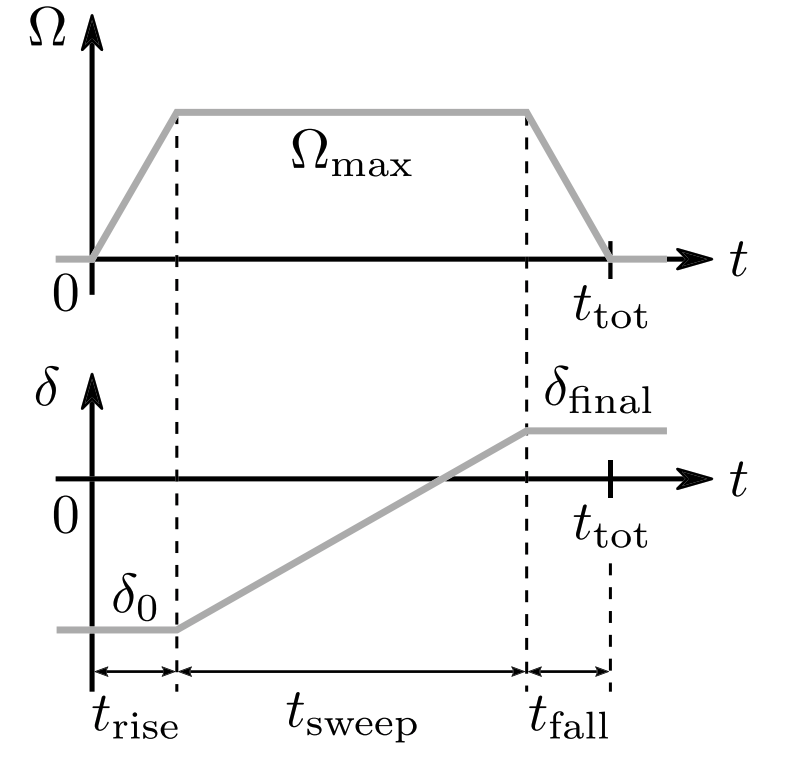
</center>

We will be working with the following set of parameters $\Omega_{max}=2.3 U$, $\delta_0 = -6 U$
$\delta_f = 2 U$

Q1 : What is the starting point of the program on the phase diagram. Draw the path corresponding to the program on the phase diagram and comment.

The pulse and the register are defined by the following parameters:

In [ ]:
# Parameters in rad/µs and ns
Omega_max = 2.3 * 2 * np.pi 
U = Omega_max / 2.3

delta_0 = -6 * U
delta_f = 2 * U

t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0)/(2 * np.pi * 10) * 700 

R_interatomic = Chadoq2.rydberg_blockade_radius(U)

N_side = 3
reg = Register.square(N_side, R_interatomic, prefix='q')
print(f'Interatomic Radius is: {R_interatomic}µm.')
reg.draw()

## Creating my sequence with Pulser
We compose our pulse with the following objects from Pulser:

In [ ]:
rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max), delta_0, 0.)
sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.), delta_f, 0.)

In [ ]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel('ising', 'rydberg_global')

seq.add(rise, 'ising')
seq.add(sweep, 'ising')
seq.add(fall, 'ising')

seq.draw()

## Simulation: Spin-Spin Correlation Function

We shall now evaluate the quality of the obtained state by calculating the *spin-spin correlation function*, defined as:


$$g^{(2)}(k,l)= \frac{1}{N_{k,l}}\sum_{(i,j) = (kR,lR)} \left[ \langle n_i n_j \rangle - \langle n_i \rangle \langle n_j \rangle \right]$$

where the $c$ indicates that we are calculating the *connected* part, and where the sum is over all pairs $(i,j)$ whose distance is ${\bf r}_i - {\bf r}_j = (k R, l R)$ in the atomic array coordinate (both $k$ and $l$ are positive or negative integers within the size of the array). In the following we will characterize the antiferromagnetic correlations in more detail.

The simulation of the sequence defined above can be run with the following code.

In [ ]:
simul = Simulation(seq, sampling_rate=0.04)
results = simul.run(progress_bar=True)

In a real experiment, one does not have access to the full wavefunction. Instead, one gets measurement samples. Those can be accessed in the following way using pulser.

In [ ]:
samples = results.sample_final_state()

In the following, we will consider only the most frequent bitstrings that appear.

In [ ]:
most_freq = {k:v for k,v in samples.items() if v>10}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation='vertical')
plt.show()

Q2: Do you have a comment on the previously obtained histogram ?

Q3: Write a few lines of code to compute $g^{(2)}(1,0)$ from the 'most_freq' dictionnary.

In the following cell, we define helper functions to help us evaluate the full correlation function.

In [ ]:
def occupation(j,N):
    up = qutip.basis(2,0)
    prod = [qutip.qeye(2) for _ in range(N)]
    prod[j] = up * up.dag()
    return qutip.tensor(prod)

def get_corr_pairs(k, l, register, R_interatomic):
    corr_pairs = []
    for i, qi in enumerate(register.qubits):
        for j, qj in enumerate(register.qubits):
            r_ij = register.qubits[qi]-register.qubits[qj]
            distance = np.linalg.norm(r_ij - R_interatomic*np.array([k, l]))
            if distance < 1:
                corr_pairs.append([i, j])
    return corr_pairs

def get_corr_function(k, l, reg, R_interatomic, state):
    N_qubits = len(reg.qubits)
    corr_pairs = get_corr_pairs(k, l, reg, R_interatomic)
    
    operators = [occupation(j, N_qubits) for j in range(N_qubits)]
    covariance = 0
    for qi, qj in corr_pairs:
        covariance += qutip.expect(operators[qi]*operators[qj], state)
        covariance -= qutip.expect(operators[qi], state)*qutip.expect(operators[qj], state)
    return covariance/len(corr_pairs)
        
def get_full_corr_function(reg, state):
    N_qubits = len(reg.qubits)
    
    correlation_function = {}
    N_side = int(np.sqrt(N_qubits))
    for k in range(-N_side+1, N_side):
        for l in range(-N_side+1, N_side):
            correlation_function[(k, l)] = get_corr_function(k, l, reg, R_interatomic, state)
    return correlation_function

With these functions, we operate on the final state of evolution obtained by our simulation.

In [ ]:
final = results.states[-1]
correlation_function = get_full_corr_function(reg, final)

In [ ]:
A = 4*np.reshape(list(correlation_function.values()), (2*N_side-1, 2*N_side-1))
A = A/np.max(A)

A[N_side-1, N_side-1] = None
plt.figure(figsize=(3.5,3.5))
plt.imshow(A, cmap='coolwarm', vmin=-.4, vmax=.4)
plt.xticks(range(len(A)), [f'{x}' for x in range(-N_side + 1, N_side)])
plt.xlabel(r'$\mathscr{k}$', fontsize=22)
plt.yticks(range(len(A)), [f'{-y}' for y in range(-N_side + 1, N_side)])
plt.ylabel(r'$\mathscr{l}$', rotation=0, fontsize=22, labelpad=10)
plt.colorbar(fraction=0.047, pad=0.02)
plt.title(r'$4\times\.g^{(2)}(\mathscr{k},\mathscr{l})$ after simulation', fontsize=14)
plt.show()

### Néel Structure Factor

One way to explore the $\Omega = 0$ line on the phase diagram is to calculate the *Néel Structure Factor*, $S_{\text{Néel}}=4 \times \sum_{(k,l) \neq (0,0)} (-1)^{|k|+|l|} g^c(k,l)$, which should be highest when the state is more antiferromagnetic. We will sweep over different values of $\delta_{\text{final}}$ to show that the region $0<\hbar \delta_{\text{final}}/U<4$ is indeed where the antiferromagnetic phase takes place.

In [ ]:
def get_neel_structure_factor(reg, R_interatomic, state):
    N_qubits = len(reg.qubits)
    N_side = int(np.sqrt(N_qubits))

    st_fac = 0
    for k in range(-N_side+1, N_side):
        for l in range(-N_side+1, N_side):
            kk = np.abs(k)
            ll = np.abs(l)
            if not (k == 0 and l == 0):
                st_fac += 4 * (-1)**(kk + ll) * get_corr_function(k, l, reg, R_interatomic, state)
    return st_fac 

In [ ]:
def calculate_neel(det, om, N, rate = 700, Omega_max = 2.3 * 2 * np.pi):
    #Setup:
    U = Omega_max / 2.3
    delta_0 = -6 * U
    delta_f = det * U  
    Omega_f = om * U 
    
    t_rise = 252
    t_fall = 500
    t_sweep = int((delta_f - delta_0)/(2 * np.pi * 10) * rate)
    t_sweep += 4 - t_sweep % 4 # To be a multiple of the clock period of Chadoq2 (4ns)
    
    R_interatomic = Chadoq2.rydberg_blockade_radius(U) 
    reg = Register.rectangle(N, N, R_interatomic)

    #Pulse Sequence
    rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max), delta_0, 0.)
    sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.)
    fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, Omega_f), delta_f, 0.)

    seq = Sequence(reg, Chadoq2)
    seq.declare_channel('ising', 'rydberg_global')
    seq.add(rise, 'ising')
    seq.add(sweep, 'ising')
    seq.add(fall, 'ising')

    simul = Simulation(seq, sampling_rate=0.3)
    results = simul.run()
    
    final = results.states[-1]
    return get_neel_structure_factor(reg, R_interatomic, final)       

In [ ]:
detunings = np.linspace(-1, 5, 20)
results=[]
for det in detunings:
    print(f'Detuning = {np.round(det,3)} x 2π Mhz.')
    results.append(calculate_neel(det, 0., N_side))
plt.xlabel(r'$\hbar\delta_{final}/U$')
plt.ylabel(r'Néel Structure Factor $S_{Neel}$')
plt.plot(detunings, results, 'o', ls='solid')
plt.show()
max_index = results.index(max(results))
print(f'Max S_Neel {np.round(max(results),2)} at detuning = {np.round(detunings[max_index],2)} x 2π Mhz.')

Let's now try to reproduce de phase diagram that we showed at the beginning of the session.

In [ ]:
results = np.zeros((20, 20))
detunings = np.linspace(-1, 5, 20)
rabis = np.linspace(0., 2.3, 20)
j = 0
k = 0
for det in detunings:
    k = 0
    for om in rabis:
        results[j, k] = calculate_neel(det, om, N_side)
        k += 1
    j+=1

In [ ]:
plt.imshow(np.flip(results, axis=0), cmap='coolwarm', vmin=0., vmax=2.8)
plt.xticks([0,5,10,15,19], [0,2.2/4,1.1,1.65,2.2])
plt.xlabel(r'$\hbar \Omega/U$', fontsize=20)
plt.yticks([0,5,10,15,19], [5,3.5,2,0.5,-1])
plt.ylabel(r'$\hbar \delta/U$', rotation=0, fontsize=22, labelpad=10)
plt.colorbar(fraction=0.047, pad=0.02)
plt.show()     

## Varying the velocity of the sweep. Adiabaticity and Landau-Zener transition 

Now we will study in more detail what happens if we change the velocity of the sweep. Q4: Use the function calculate_neel defined above to study what happens to the final value of the Neel factor when one changes the velocity of the sweep.

We will study this phenomenon in more detail.

In [ ]:
def hamiltonian_t(t, args):
    """ evaluate the hamiltonian at time t. """
    H0 = args[0]
    H1 = args[1]

    return H0 + t * H1

def qubit_integrate(omega, eps0, A, gamma1, gamma2, psi0, tlist):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    sm = destroy(2)

    H0 = - omega/2.0 * sx - eps0/2.0 * sz
    H1 = - A/2.0 * sz        

    # collapse operators
    c_op_list = []

    n_th = 0.0 # zero temperature

    # relaxation
    rate = gamma1 * (1 + n_th)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sm)

    # excitation
    rate = gamma1 * n_th
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sm.dag())

    # dephasing 
    rate = gamma2
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sz)

    # evolve and calculate expectation values

    # method 1: function callback which returns the time-depdent qobj
    #H_args = (H0, H1)
    #output = mesolve(hamiltonian_t, psi0, tlist, c_op_list, [sm.dag() * sm], H_args)  

    # method 2: a function callback that returns the coefficient for a qobj
    #H = [H0, [H1, lambda x,y: x]]
    #output = mesolve(H, psi0, tlist, c_op_list, [sm.dag() * sm], {})  

    # method 3: a string that defines the coefficient. The solver generates
    # and compiles C code using cython. This method is usually the fastest
    # for large systems or long time evolutions, but there is fixed-time
    # overhead that makes it inefficient for small and short-time evolutions.
    H = [H0, [H1, 't']]
    output = mesolve(H, psi0, tlist, c_op_list, [sm.dag() * sm], {})  

    return output.expect[0]

In [ ]:
#
# set up the calculation
#
omega = 0.5 * 2 * np.pi   # qubit sigma_x coefficient
eps0  = 0.0 * 2 * np.pi   # qubit sigma_z coefficient
A     = 3.0 * 2 * np.pi   # sweep rate
gamma1 = 0.0           # relaxation rate
gamma2 = 0.0           # dephasing  rate
psi0 = basis(2,0)      # initial state
tlist = np.linspace(-20.0, 20.0, 5000)

In [ ]:
A = 3.0 * 2 * np.pi   # sweep rate
p_ex = qubit_integrate(omega, eps0, A, gamma1, gamma2, psi0, tlist)
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(tlist, np.real(p_ex), 'b', tlist, np.real(1-p_ex), 'r')
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability')
ax.set_title('Landau-Zener transition')

Q5 : Play with the parameter A, comment on the dynamics.